#### 1. Librerias y configuraciones previas

In [89]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================

from scipy.stats import pearsonr
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#Escalar Variables
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import math


#Creacion de los modelos
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import sklearn.metrics as metrics

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#Creacion de los modelos bayesianos
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

#Creacion de los modelos KNN vs Gaussian
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import LogisticRegression

# Preprocesado y modelado Maquina de vector de soporte
# ==============================================================================
from scipy.stats import pearsonr
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import math

# Preprocesado y modelado Random Forest
# ==============================================================================

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


#creación de modelos Random Forest
from sklearn.ensemble import RandomForestClassifier


#import statsmodels.api as sm Random Forest
import math
import statsmodels.api as sm


#evaluacion de variables
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

#Escalar Variables
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor # Algoritmo LOF

import statsmodels.api as sm
import math

#from sklearn.svm import LinearSVC

from sklearn import svm
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Permitir ver todas las filas y columnas
pd.set_option("display.max_rows", None, "display.max_columns", None)

#### 2. Carga del dataset

In [90]:
df_tenis=pd.read_csv('data/tennis_matches.csv')
df_tenis.info() # Se comprueba que el archivo contenga los datos, los nombres de las columnas y el tipo de dato de cada columna.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169690 entries, 0 to 169689
Data columns (total 49 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   best_of             169690 non-null  int64  
 1   draw_size           1232 non-null    float64
 2   l_1stIn             83415 non-null   float64
 3   l_1stWon            83415 non-null   float64
 4   l_2ndWon            83415 non-null   float64
 5   l_SvGms             83415 non-null   float64
 6   l_ace               83415 non-null   float64
 7   l_bpFaced           83415 non-null   float64
 8   l_bpSaved           83415 non-null   float64
 9   l_df                83415 non-null   float64
 10  l_svpt              83415 non-null   float64
 11  loser_age           164700 non-null  float64
 12  loser_entry         25339 non-null   object 
 13  loser_hand          169605 non-null  object 
 14  loser_ht            139052 non-null  float64
 15  loser_id            169690 non-nul

#### 3. Limpieza de datos y preparación

Revisando los tipos de datos se evidencia que hay 5 variables de tipo entero, 14 de tipo string y 30 de tipo flotante. Asimismo en todas las variables menos en 13 existen registros faltantes.

<AxesSubplot:title={'center':'Número de registros no nulos de l_1sIn por años'}, xlabel='Rango de fechas', ylabel='Número de registros no nulos'>

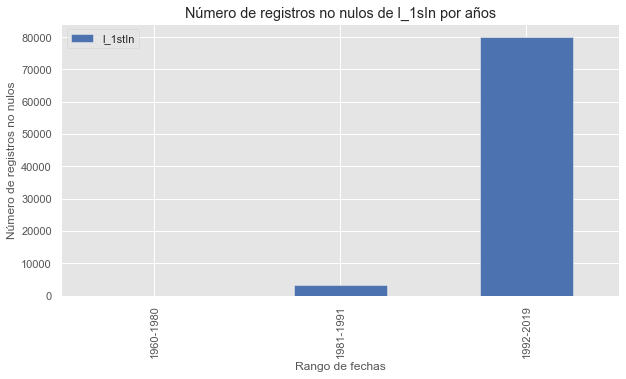

In [91]:
df_tenis["Anio"]=df_tenis["tourney_date"].astype("str").str[:4].astype("int") #Se crea una columna con el año del torneo
df_tenis["Anio_agrupado"]=df_tenis[["Anio"]].apply(lambda x: "1960-1980" if (x["Anio"]<=1980) else "1981-1991" if (x["Anio"]<=1991) else "1992-2019", axis=1) #Se crea una nueva columna con el fin de agrupar por años 
df_tenis.groupby("Anio_agrupado")["l_1stIn"].count().to_frame().plot.bar(figsize=(10,5),color="b",ylabel="Número de registros no nulos",xlabel="Rango de fechas", title="Número de registros no nulos de l_1sIn por años") #Se crea un gráfico de barr

Cuando se grafica por años se evidencia que la mayor cantidad de datos no nulos que hay en la base están desde el año 1992, estando en línea con la descripción del dataset donde se indica que las estadísticas del partido sólo están disponibles desde al año 1991. Por lo tanto se toma la decisión de eliminar los datos de años inferiores a 1992.

In [92]:
df_tenis=df_tenis[df_tenis["Anio"]>=1992]  #Se mantienen en la base de datos los registros de años superiores a 1991
df_tenis.drop(["Anio","Anio_agrupado"], axis=1 , inplace=True) #Se eliminan las columnas creadas anteriormente

También, se decide trabajar únicamente con datos de partidos entre jugadores rankeados entre los 100 primeros del mundo y sólo en torneos de categoría G, M o A por lo que se eliminarán también los registros que no correspondan con ello.

In [93]:
df_tenis=df_tenis[(df_tenis["loser_rank"]<=100) & (df_tenis["winner_rank"]<=100)& (df_tenis["tourney_level"]=="G") | (df_tenis["tourney_level"]=="M") | (df_tenis["tourney_level"]=="A")] #Se excluyen los registros que no correspondan a jugadores del top 100 y ni torneos diferentes a G, M o A.
df_tenis.shape  #Tamaño del dataframe.

(74918, 49)

El nuevo dataset contiene 74.918 filas y 49 columnas

In [94]:
# Revisión de duplicados
df_tenis.loc[df_tenis.duplicated()]

,best_of,draw_size,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_ace,l_bpFaced,l_bpSaved,l_df,l_svpt,loser_age,loser_entry,loser_hand,loser_ht,loser_id,loser_ioc,loser_name,loser_rank,loser_rank_points,loser_seed,match_num,minutes,round,score,surface,tourney_date,tourney_id,tourney_level,tourney_name,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_ace,w_bpFaced,w_bpSaved,w_df,w_svpt,winner_age,winner_entry,winner_hand,winner_ht,winner_id,winner_ioc,winner_name,winner_rank,winner_rank_points,winner_seed


No se evidencian registros duplicados en el dataset y se indagará acerca de los registros nulos que aún están en el mismo.

In [95]:
# Se reemplaza los valores "?" por np.nan
df_tenis.replace('?',np.nan, inplace=True) 
# Crear DataFrame para almacenar información
null_counts = pd.DataFrame({'columna': df_tenis.columns, 'cantidad_nulos': df_tenis.isnull().sum()})

# Imprimir información con los valores nulos por columna de aquellas con mayor cantidad de nulos
null_counts.sort_values("cantidad_nulos", ascending=False, inplace=True)
null_counts.head(15)

,columna,cantidad_nulos
draw_size,draw_size,74918
winner_entry,winner_entry,65694
loser_entry,loser_entry,59889
loser_seed,loser_seed,55740
winner_seed,winner_seed,40782
loser_ht,loser_ht,3665
minutes,minutes,2380
winner_ht,winner_ht,2103
w_2ndWon,w_2ndWon,1176
w_SvGms,w_SvGms,1176


Se encuentra que la mayor cantidad de registros nulos se dan en 3 variables: draw_size, entry y seed. Ninguna de ellas corresponde a estadísticas propias del desempeño de los jugadores en el partido y se considera que son datos que no aportarían valor al modelo de clasificación por lo que se decide eliminar dichas variables. Además, en muchas columnas se evidencia la misma cantidad de datos nulos (1176) lo cual indica que no hay valores en todas esas líneas por lo que se excluyen también del set de datos ya que no aportan valor al modelo al no tener información.

In [96]:
df_tenis.drop(["draw_size","winner_entry","loser_entry","loser_seed","winner_seed"], axis=1, inplace=True) # Se eliminan las columnas que no son necesarias

df_tenis.dropna(subset=['w_1stWon'], inplace=True)

Se eliminan las columnas y se verifican nuevamente los registros nulos restantes.

In [97]:
# Se reemplaza los valores "?" por np.nan
df_tenis.replace('?',np.nan, inplace=True) 
# Crear DataFrame para almacenar información
null_counts = pd.DataFrame({'columna': df_tenis.columns, 'cantidad_nulos': df_tenis.isnull().sum()})

# Imprimir información con los valores nulos por columna de aquellas con mayor cantidad de nulos
null_counts.sort_values("cantidad_nulos", ascending=False, inplace=True)
null_counts[null_counts["cantidad_nulos"]>0]

,columna,cantidad_nulos
loser_ht,loser_ht,3648
winner_ht,winner_ht,2091
minutes,minutes,1215
loser_rank_points,loser_rank_points,963
winner_rank_points,winner_rank_points,803
loser_rank,loser_rank,230
winner_rank,winner_rank,62
loser_age,loser_age,25
winner_age,winner_age,1
score,score,1


Los registros restantes con valores nulos se consideran no representativos por lo que se decide eliminarlos

In [98]:
df_tenis.dropna(inplace=True) #Se eliminan los registros nulos restantes en el dataset

In [99]:
# Se reemplaza los valores "?" por np.nan
df_tenis.replace('?',np.nan, inplace=True) 
# Crear DataFrame para almacenar información
null_counts = pd.DataFrame({'columna': df_tenis.columns, 'cantidad_nulos': df_tenis.isnull().sum()})

# Imprimir información con los valores nulos por columna de aquellas con mayor cantidad de nulos
null_counts.sort_values("cantidad_nulos", ascending=False, inplace=True)
null_counts[null_counts["cantidad_nulos"]>0]

,columna,cantidad_nulos


Al verificar nuevamente se evidencia que ya no existen registros nulos en la base de datos

##### 3.1 Análisis de Correlación

In [100]:
corr = df_tenis.corr ()
corr.style.background_gradient (cmap = 'coolwarm')

,best_of,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_ace,l_bpFaced,l_bpSaved,l_df,l_svpt,loser_age,loser_ht,loser_id,loser_rank,loser_rank_points,match_num,minutes,tourney_date,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_ace,w_bpFaced,w_bpSaved,w_df,w_svpt,winner_age,winner_ht,winner_id,winner_rank,winner_rank_points
best_of,1.000000,0.493422,0.456740,0.347808,0.540738,0.201380,0.353632,0.259291,0.198558,0.528119,0.026124,0.019631,0.048010,-0.131834,0.111107,0.194058,0.341730,0.060570,0.487105,0.527756,0.380116,0.548712,0.246723,0.204979,0.178714,0.176271,0.498231,0.015851,0.030055,0.054625,-0.144889,0.169444
l_1stIn,0.493422,1.000000,0.949216,0.561328,0.875278,0.395198,0.458985,0.489329,0.212537,0.926174,0.023189,0.049061,0.041200,-0.099782,0.108619,0.125363,0.742997,0.050924,0.796749,0.797995,0.605663,0.861813,0.339977,0.471907,0.368194,0.340284,0.825711,0.028500,0.048993,0.039565,-0.046003,0.043910
l_1stWon,0.456740,0.949216,1.000000,0.606614,0.897551,0.545975,0.309717,0.399345,0.267395,0.914417,0.033583,0.126468,0.046402,-0.112717,0.128916,0.129273,0.738296,0.060881,0.815105,0.847799,0.655196,0.888474,0.415657,0.416962,0.343810,0.351608,0.846098,0.039034,0.087323,0.044815,-0.041820,0.036468
l_2ndWon,0.347808,0.561328,0.606614,1.000000,0.767702,0.421901,0.283316,0.358942,0.329401,0.783754,-0.002515,0.040532,-0.012890,-0.089204,0.082417,0.069795,0.664968,-0.013441,0.658675,0.680123,0.621661,0.758085,0.335772,0.388628,0.317097,0.351613,0.726701,0.019902,0.055192,-0.024336,-0.021867,-0.005759
l_SvGms,0.540738,0.875278,0.897551,0.767702,1.000000,0.492069,0.364028,0.353475,0.317764,0.934847,0.018932,0.072215,0.026715,-0.117825,0.123202,0.126158,0.807141,0.035818,0.871723,0.872206,0.713637,0.982510,0.383555,0.544103,0.425448,0.411956,0.926110,0.025116,0.048930,0.024402,-0.043019,0.029633
l_ace,0.201380,0.395198,0.545975,0.421901,0.492069,1.000000,-0.017515,0.096414,0.251016,0.457096,0.035632,0.358938,0.063819,-0.090208,0.119551,0.095889,0.366125,0.080804,0.427851,0.487415,0.393138,0.488765,0.309574,0.112809,0.115421,0.186734,0.442010,0.071881,0.036614,0.050733,-0.026735,0.037707
l_bpFaced,0.353632,0.458985,0.309717,0.283316,0.364028,-0.017515,1.000000,0.921744,0.248180,0.519459,-0.025340,-0.097727,-0.038916,-0.020312,-0.002667,0.039175,0.360573,-0.047729,0.299503,0.225834,0.195777,0.343280,-0.053145,0.370939,0.243630,0.167565,0.329251,-0.027554,-0.121295,-0.037173,-0.043497,0.038586
l_bpSaved,0.259291,0.489329,0.399345,0.358942,0.353475,0.096414,0.921744,1.000000,0.226784,0.541147,-0.008725,-0.036970,-0.017228,-0.025937,0.013033,0.039954,0.372010,-0.020082,0.300726,0.269361,0.228195,0.341821,0.042359,0.266954,0.191782,0.153294,0.324448,-0.006144,-0.056671,-0.017937,-0.035118,0.030194
l_df,0.198558,0.212537,0.267395,0.329401,0.317764,0.251016,0.248180,0.226784,1.000000,0.367304,-0.036373,0.099101,-0.077298,-0.007692,-0.018303,0.004341,0.228804,-0.086603,0.251534,0.250865,0.256323,0.306521,0.111835,0.197196,0.147566,0.236422,0.298020,-0.009050,-0.018662,-0.087087,0.036443,-0.055614
l_svpt,0.528119,0.926174,0.914417,0.783754,0.934847,0.457096,0.519459,0.541147,0.367304,1.000000,0.007927,0.053892,0.006201,-0.105437,0.104141,0.115904,0.794009,0.010499,0.831287,0.828890,0.675159,0.918360,0.343624,0.519260,0.402722,0.393431,0.883891,0.019584,0.026203,0.001097,-0.046856,0.033101


Se eliminan las variables que presentan correlacion superior al 80% y aquellas otras que no son relevantes de cara al modelo

In [101]:
df_tenis= df_tenis.drop(["l_SvGms","w_SvGms","w_1stWon","l_1stWon","minutes","l_svpt","w_svpt","l_bpSaved","w_bpSaved","l_1stIn","w_1stIn","loser_ioc","tourney_date","loser_id","winner_id","match_num","winner_rank_points","loser_rank_points","best_of","tourney_id","tourney_name","winner_ioc","round","score"], axis=1) # Se eliminan las variables que presentan una alta correlacion así como las variables que no aportan información relevante de cara a lo que se quiere predecir como el id del jugador, rank_points_match_num, best_of

In [102]:
corr = df_tenis.corr ()
corr.style.background_gradient (cmap = 'coolwarm')

,l_2ndWon,l_ace,l_bpFaced,l_df,loser_age,loser_ht,loser_rank,w_2ndWon,w_ace,w_bpFaced,w_df,winner_age,winner_ht,winner_rank
l_2ndWon,1.000000,0.421901,0.283316,0.329401,-0.002515,0.040532,-0.089204,0.621661,0.335772,0.388628,0.351613,0.019902,0.055192,-0.021867
l_ace,0.421901,1.000000,-0.017515,0.251016,0.035632,0.358938,-0.090208,0.393138,0.309574,0.112809,0.186734,0.071881,0.036614,-0.026735
l_bpFaced,0.283316,-0.017515,1.000000,0.248180,-0.025340,-0.097727,-0.020312,0.195777,-0.053145,0.370939,0.167565,-0.027554,-0.121295,-0.043497
l_df,0.329401,0.251016,0.248180,1.000000,-0.036373,0.099101,-0.007692,0.256323,0.111835,0.197196,0.236422,-0.009050,-0.018662,0.036443
loser_age,-0.002515,0.035632,-0.025340,-0.036373,1.000000,-0.009886,-0.067216,-0.004475,0.080159,-0.028172,-0.013066,0.135663,0.053576,-0.025242
loser_ht,0.040532,0.358938,-0.097727,0.099101,-0.009886,1.000000,-0.050299,0.054586,0.021877,-0.061213,-0.002758,0.046849,0.029610,-0.033292
loser_rank,-0.089204,-0.090208,-0.020312,-0.007692,-0.067216,-0.050299,1.000000,-0.082645,-0.064609,-0.059901,-0.009459,-0.017792,-0.040816,0.133884
w_2ndWon,0.621661,0.393138,0.195777,0.256323,-0.004475,0.054586,-0.082645,1.000000,0.308496,0.431749,0.397162,0.000308,0.019061,-0.029400
w_ace,0.335772,0.309574,-0.053145,0.111835,0.080159,0.021877,-0.064609,0.308496,1.000000,0.012674,0.246763,0.040052,0.403653,-0.076971
w_bpFaced,0.388628,0.112809,0.370939,0.197196,-0.028172,-0.061213,-0.059901,0.431749,0.012674,1.000000,0.374526,-0.018139,-0.101347,0.041786


In [103]:
df_tenis.shape

(66715, 20)

##### 3.2 Variable a predecir

Se crea una variable llamada "Resultado" que podrá tomar dos valores: P: Perdedor, G:Ganador. Teniendo en cuenta que inicialmente el jugador de referencia será "loser_name", la variable nueva tendrá el valor "P"

In [104]:
df_tenis["Resultado"]="P"

Se crean dos nuevos datasets, uno que contenga la información del jugador perdedor y otra con el ganador, compartiendo en ambos datasets las variables comunes a ambos en los partidos y que no dependen del desempeño del jugador en el encuentro como lo son: surface, tourney_level, y el nombre del oponente.


In [105]:
loser=df_tenis.rename(columns={"l_2ndWon":"J1_2ndWon","l_ace":"J1_ace","l_bpFaced":"J1_bpFaced","l_df":"J1_df","loser_age":"J1_age","loser_hand":"J1_hand","loser_ht":"J1_ht","loser_name":"J1_name","loser_rank":"J1_rank","w_2ndWon":"J2_2ndWon","w_ace":"J2_ace","w_bpFaced":"J2_bpFaced","w_df":"J2_df","winner_age":"J2_age","winner_hand":"J2_hand","winner_ht":"J2_ht","winner_name":"J2_name","winner_rank":"J2_rank"}) #Se cambian los nombres de las columnas y el jugador 1 siempre es el perdedor

winner=df_tenis.rename(columns={"l_2ndWon":"J2_2ndWon","l_ace":"J2_ace","l_bpFaced":"J2_bpFaced","l_df":"J2_df","loser_age":"J2_age","loser_hand":"J2_hand","loser_ht":"J2_ht","loser_name":"J2_name","loser_rank":"J2_rank","w_2ndWon":"J1_2ndWon","w_ace":"J1_ace","w_bpFaced":"J1_bpFaced","w_df":"J1_df","winner_age":"J1_age","winner_hand":"J1_hand","winner_ht":"J1_ht","winner_name":"J1_name","winner_rank":"J1_rank"}) #Se cambian los nombres de las columnas y a las columnas del winner se le asigna el nombre "J1" para concatener el dataframe con el de loser

winner["Resultado"]="G"  #Se asigna el valor de "G" a resultado ya que se invirtió el orden de los jugadores


Se concatenan los datasets para crear el conjunto completo donde se tendrá la variable a predecir y se convierten a entero aquellas variables que tenían un tipo flotante.

In [106]:
df_tenis= pd.concat([loser, winner]).reset_index().drop("index", axis=1) # Se concatenan los datasets y ya se tiene una variable objetivo "Resultado" que será la que se querrá predecir con el modelo

# Se convierten todas las columnas flotantes en enteras
df_tenis[['J1_2ndWon', 'J1_ace', 'J1_bpFaced', 'J1_df', 'J1_age', 'J1_ht', 'J2_2ndWon', 'J2_ace', 'J2_bpFaced', 'J2_df', 'J2_age', 'J2_ht',"J1_rank","J2_rank"]]=df_tenis[['J1_2ndWon', 'J1_ace', 'J1_bpFaced', 'J1_df', 'J1_age', 'J1_ht', 'J2_2ndWon', 'J2_ace', 'J2_bpFaced', 'J2_df', 'J2_age', 'J2_ht',"J1_rank","J2_rank"]].astype("int")

df_tenis.shape

(133430, 21)

##### 3.2 Visualización de datos

Al duplicar la base de datos, si se grafica la variable a predecir "Resultado" se debe de contar con el mismo número de registros para las categorías "P" y "G"

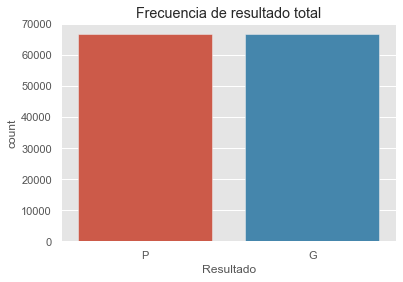

In [107]:
df_tenis.groupby('Resultado').Resultado.count().sort_values(ascending=False)
plt.figure(figsize=(6,4))  

plt.title('Frecuencia de resultado total')
sns.countplot(x=df_tenis['Resultado'])

plt.show()

No osbtante, si se revisa la base de datos para un jugador específico la proporción es diferente.

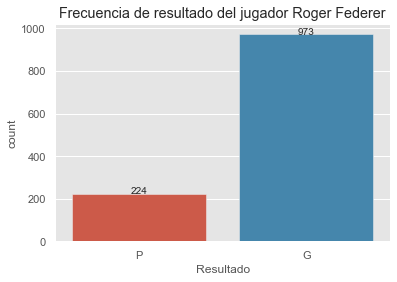

In [108]:
federer=df_tenis[df_tenis["J1_name"]=="Roger Federer"]
plt.figure(figsize=(6,4))
plt.title('Frecuencia de resultado del jugador Roger Federer')
sns.countplot(x=federer['Resultado'])
labels = federer['Resultado'].unique()
for i, label in enumerate(labels):
    count = federer[federer['Resultado'] == label].shape[0]
    plt.text(i, count, str(count), ha='center')
plt.xticks(range(len(labels)), labels)
plt.show()

##### 3.3 Variables categóricas

Se crea una variable que contenga únicamente las columnas categóricas de la base de datos, se crea una función para graficarlas y se revisa como se visualiza la distribución.

In [109]:
catCols=df_tenis.select_dtypes(include = ["object"]).columns.tolist() #Se crea la columna catCols que contiene las variables categóricas
catCols.remove('Resultado') # Se excluye la columna Resultado ya que es la variable a predecir.

In [110]:
#Función para graficar múltiples gráficas
def plot_multiples_graficas(df, cols, num_cols, num_rows, tipo, targetVar, figsize=(16,8)):
    
    plt.rcParams['figure.figsize'] = figsize
    
    #num_plots = len(cols)
    #num_cols = math.ceil(np.sqrt(num_plots))
    #num_rows = math.ceil(num_plots/num_cols)
        
    fig, axs = plt.subplots(num_rows, num_cols)
    
    for ind, col in enumerate(cols):
        i = math.floor(ind/num_cols)
        j = ind - i*num_cols
        
        if num_rows == 1:
            if num_cols == 1:
                if tipo == 'c': 
                    sns.countplot(x=df[col], ax=axs, dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs)
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs)
            else:
                if tipo == 'c':
                    sns.countplot(x=df[col], ax=axs[j], dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs[j])
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs[j])
        else:
            if num_cols == 1:
                if tipo == 'c':
                    sns.countplot(x=d[col], ax=axs[i], dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs[i])
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs[i])
            else:
                if tipo == 'c':
                    sns.countplot(x=df[col], ax=axs[i, j], dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs[i, j])
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs[i, j])

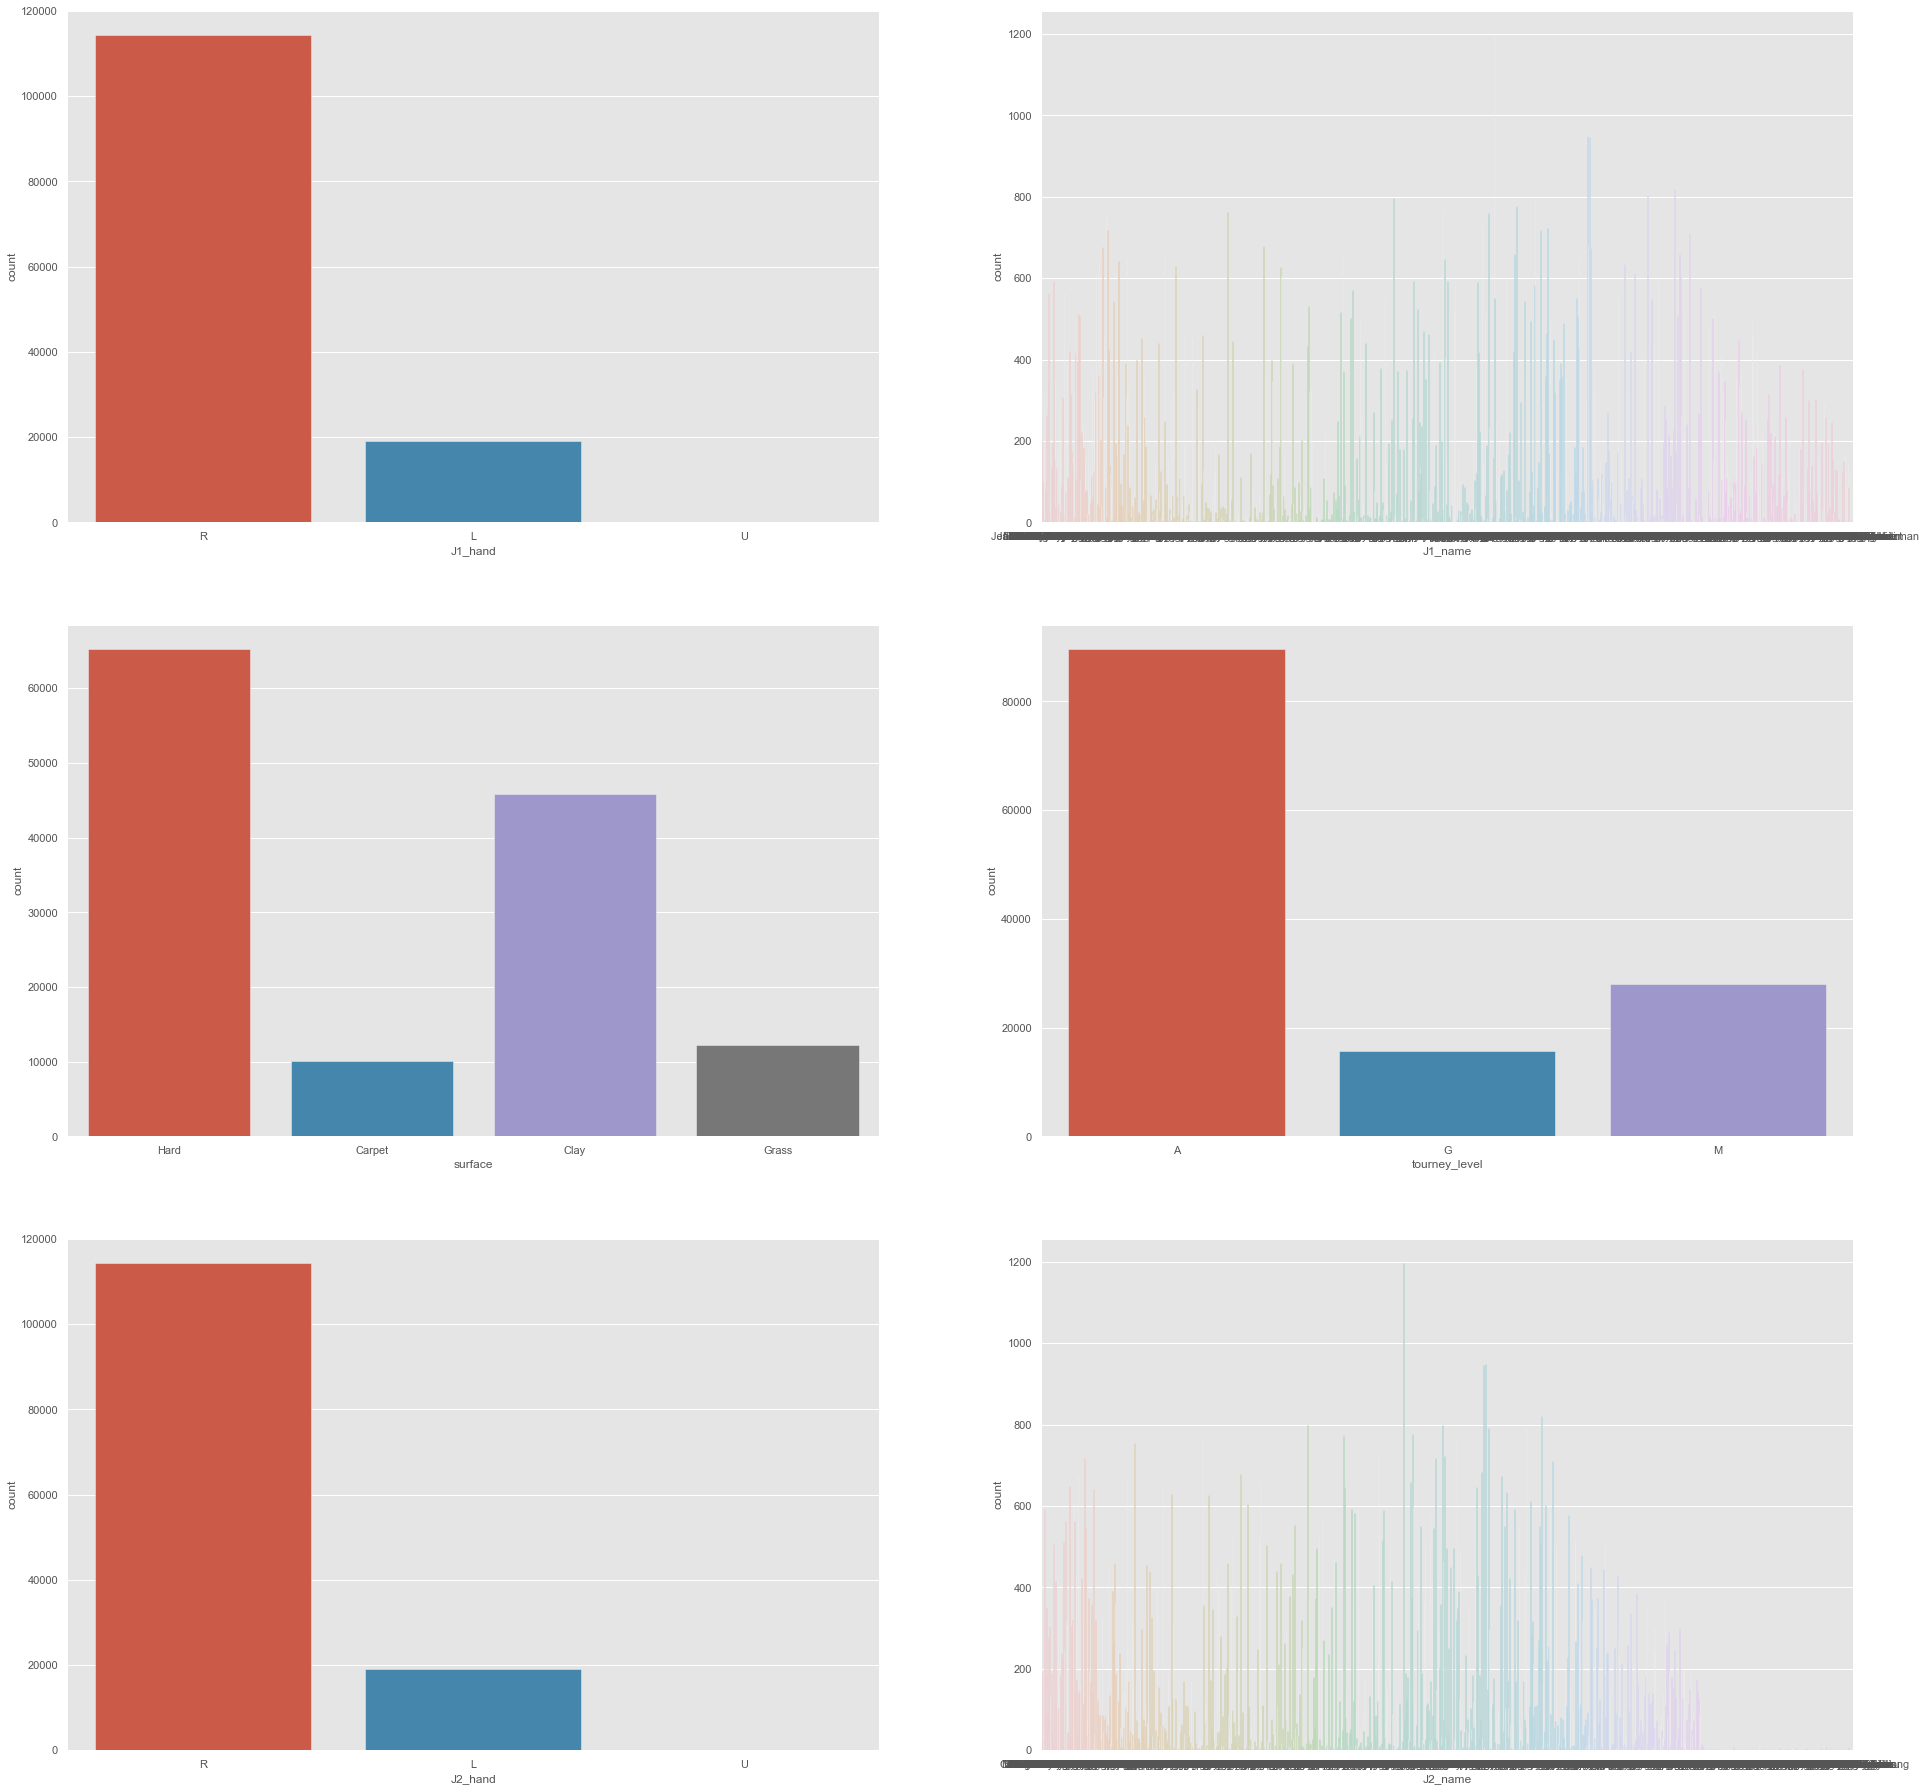

In [111]:
plot_multiples_graficas(df_tenis,catCols, 2, 3, 'c', None, (32,32))

Se evidencia que la mano dominante de los jugadores presenta tres clases: R (Right), L (Left) y U (Unknown). Se procede a verificar los registros que presentan la descripción "U"

In [112]:
print(df_tenis[df_tenis["J1_hand"]=="U"].shape)
print(df_tenis[df_tenis["J2_hand"]=="U"].shape)

(29, 21)
(29, 21)


Se evidencian que son 29 registros con la descripción en "U" por lo que al ser tan poco representativos se decide eliminarlos de la base de datos.

In [113]:
df_tenis=df_tenis[(df_tenis["J1_hand"]!="U") & (df_tenis["J2_hand"]!="U")]

Asimismo, se evidencia que no es posible interpretar los gráficos de los nombres de jugadores debido a la gran cantidad de tenistas que han estado en el top100 durante el tiempo de medición y si se crean variable dummies con base en dicha columna, convertiría el dataset en una base con mas de mil columnas lo cual es muy dificil de procesar para un modelo. Por lo tanto y teniendo en cuenta que los jugadores se pueden identificar aún con la posición del ranking (rank) se decide eliminar los nombres de los jugadores de la base.

In [114]:
df_tenis.drop(["J1_name","J2_name"], axis=1, inplace=True)

In [115]:
copia=df_tenis.copy()

#### 4. Creación de Variables Dummies

Con base en las columnas categóricas se crean las variables dummies para preparar la data para el modelo

In [116]:
# Aplicación de la función de usuario Dummies: one-hot encoding

dummie =pd.get_dummies(df_tenis, drop_first=1)
dummie.columns

Index(['J1_2ndWon', 'J1_ace', 'J1_bpFaced', 'J1_df', 'J1_age', 'J1_ht',
       'J1_rank', 'J2_2ndWon', 'J2_ace', 'J2_bpFaced', 'J2_df', 'J2_age',
       'J2_ht', 'J2_rank', 'J1_hand_R', 'surface_Clay', 'surface_Grass',
       'surface_Hard', 'tourney_level_G', 'tourney_level_M', 'J2_hand_R',
       'Resultado_P'],
      dtype='object')

Se crean las variables y se evidencia que la variable a predecir toma el nombre de "Resultado_P". Para fines de mayor entendimiento se renombrará la variable y los valores que la misma puede tomar.

In [117]:
dummie.rename(columns={"Resultado_P":"Resultado"}, inplace=True)
dummie["Resultado"].replace(1,"P", inplace=True)  #Se reemplaza el valor de Uno por P (Perdedor)
dummie["Resultado"].replace(0,"G", inplace=True)  #Se reemplaza el valor de Cero por G(Ganador)
dummie.Resultado.unique()

array(['P', 'G'], dtype=object)

#### 5. Dividir el conjunto de datos

En este caso, el 80% de los datos se utilizarán para entrenar el modelo.

In [118]:
# División de los datos en train y test
# ==============================================================================
cols = list(dummie.columns)
cols.remove('Resultado')

X = dummie[cols]
y = dummie['Resultado']

In [119]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1), 
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

#### 6. Creación del modelo

In [120]:
#Creación del modelo 
modelLR = LogisticRegression()

#Entrenamiento del modelo con 80% de training
modelLR.fit(X_train, y_train)

LogisticRegression()

In [121]:
y_LR = modelLR.predict(X_test)
print("modelLR:",metrics.accuracy_score(y_test, y_LR))

modelLR: 0.839025304592315


Se obtiene un accuracy de 83% lo cual indica que la capacidad predictora del modelo es muy buena. A continuación, se graficará la matriz de confusión para evidenciar las predicciones acertadas respecto del conjunto de prueba.

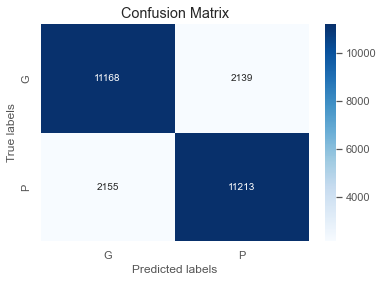

              precision    recall  f1-score   support

           G       0.84      0.84      0.84     13307
           P       0.84      0.84      0.84     13368

    accuracy                           0.84     26675
   macro avg       0.84      0.84      0.84     26675
weighted avg       0.84      0.84      0.84     26675



In [122]:
# Hacer predicciones en el conjunto de prueba
y_pred = modelLR.predict(X_test)

# Definir etiquetas para la matriz de confusión
labels = np.unique(y_test)

# Calcular la matriz de confusión con etiquetas definidas
conf_mat = confusion_matrix(y_test, y_pred, labels=labels)

# Graficar la matriz de confusión con etiquetas definidas
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', ax=ax,
            xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

# Imprimir el reporte de clasificación
print(classification_report(y_test, y_pred, target_names=labels))

#### 7. Creación del modelo con datos escalados

Inicialmente se realizará una verificación de los datos atípicos de la base de datos original y luego con los datos escalados.

In [123]:
dummie_scaled=dummie.replace("P",1).replace("G",0)

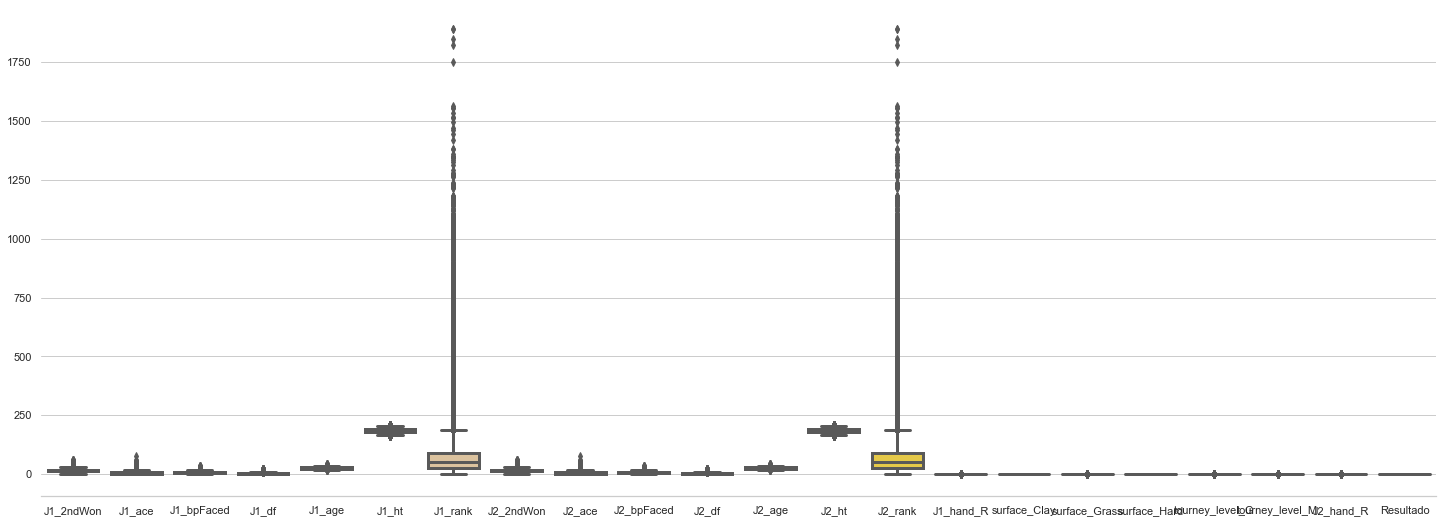

In [124]:
MinMax = MinMaxScaler(copy=True, feature_range=(0, 1)) # Método MinMax con valores entre 0 y 1
data_Min_Max = MinMax.fit_transform(dummie_scaled) # Transformación de los nuevos datos con una escala MinMax
data_Min_Max = pd.DataFrame(data = dummie_scaled, columns = dummie_scaled.columns.values.tolist())
sns.set(rc={'figure.figsize':(25,9)}) # Tamaño de la figura
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = data_Min_Max, linewidth = 3, palette="Set2", fliersize = 5) # Diagrama Box Plot con los datos con normalización Min-Max
sns.despine(left=True)

Se evidencia que las escalas son muy diferentes y se identifican datos atípicos en las variables del ranking. Se procede a escalar los datos y realizar la misma evaluación.

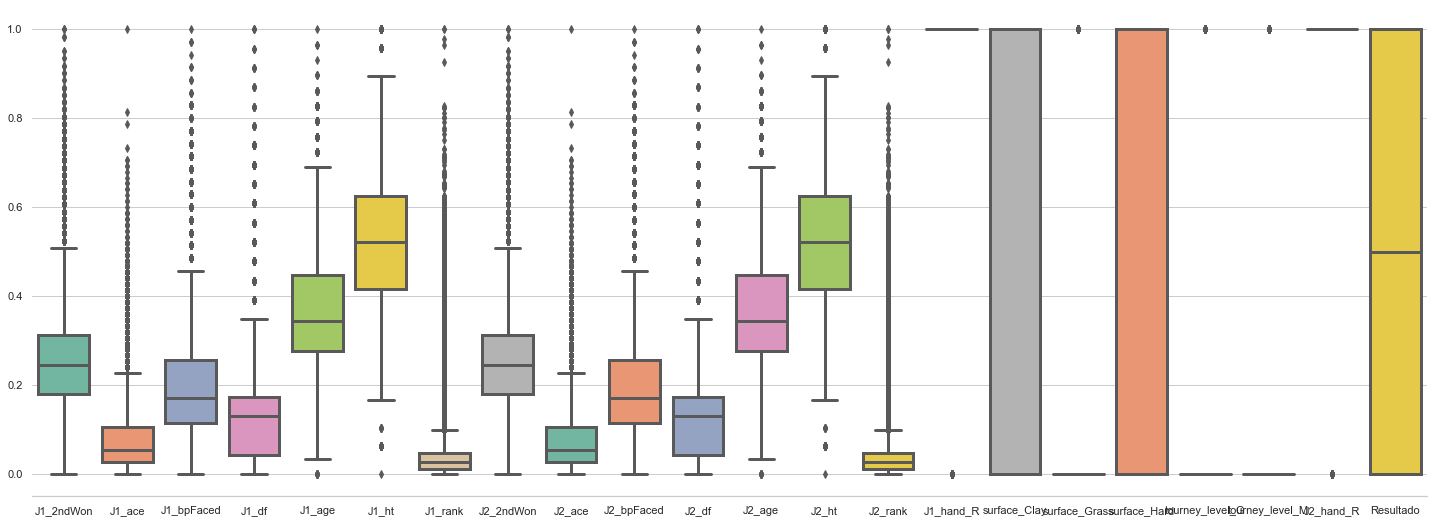

In [125]:
MinMax_1 = MinMaxScaler(copy=True, feature_range=(0, 1)) # Método MinMax con valores entre 0 y 1
data_Min_Max = MinMax_1.fit_transform(dummie_scaled) # Transformación de los nuevos datos con una escala MinMax
data_Min_Max = pd.DataFrame(data = data_Min_Max, columns = dummie_scaled.columns.values.tolist())
sns.set(rc={'figure.figsize':(25,9)}) # Tamaño de la figura
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = data_Min_Max, linewidth = 3, palette="Set2", fliersize = 5) # Diagrama Box Plot con los datos con normalización Min-Max
sns.despine(left=True)

Se observa que existen datos atípicos en casi todas las variables. Por lo tanto se realizará una eliminación de estos sacrificando la mínima cantidad de información posible.

In [126]:
LOF = LocalOutlierFactor(n_neighbors = 5, algorithm = 'auto', contamination = 'auto', metric = 'euclidean') 
# OJO, usar un número de vecinos más cercano con números impares.

Filtrado = LOF.fit_predict(data_Min_Max) # Se realiza la predicción de los datos atípicos

NOF = LOF.negative_outlier_factor_ # Detecta los valores positivos y negativos (residuos). Si los valores son grandes, entonces son valores no atípicos y por lo general, son valores cercanos a -1.
                                   # Si los valores son positivos y grandes y cercanos a 1, entonces son valores atípicos. La opción negative_outlier_dactor_ calcula dichos valores por 
                                   # la media de la relación entre la densidad local de una muestra y las de sus vecinos más cercanos.

radio_outiler = (NOF.max() - NOF)/(NOF.max() - NOF.min()) # radio de detección de datos atípicos
ground_truth = np.ones(len(data_Min_Max), dtype = int) 
# Se recomienda para luego comparar que datos es o no atípico (genera un vector de 1 o -1)
n_errors = (Filtrado != ground_truth).sum() # número de datos atípicos

In [127]:
print("Número de muestras o filas con datos atípicos: ", n_errors)

Número de muestras o filas con datos atípicos:  914


In [128]:
pos = np.where(Filtrado == ground_truth) # Se identifican en que muestras o filas de nuestra base de datos hay presencia de datos atípicos
pos = np.asarray(pos)
pos = np.hstack(pos)
df_tenis_scaled = data_Min_Max.loc[pos, :]
print("Número de muestras sin outilers:", df_tenis_scaled.shape[0])

Número de muestras sin outilers: 132458


In [129]:
print(dummie_scaled.shape) # Tamaño de los datos originales
print(df_tenis_scaled.shape) # Tamañno de los datos sin outliers 

(133372, 22)
(132458, 22)


In [142]:
df_tenis_scaled["Resultado"].replace(1, "P", inplace=True)
df_tenis_scaled["Resultado"].replace(0, "G", inplace=True)

Dividir el conjunto de datos

In [143]:
# División de los datos en train y test
# ==============================================================================
cols_scaled = list(df_tenis_scaled.columns)
cols_scaled.remove('Resultado')

Xs = df_tenis_scaled[cols_scaled]
ys = df_tenis_scaled['Resultado']

In [144]:
X_trains, X_tests, y_trains, y_tests = train_test_split(
                                        Xs,
                                        ys.values.reshape(-1,1), 
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [153]:
#Creación del modelo 
modelLRs = LogisticRegression()

#Entrenamiento del modelo con 80% de training
modelLRs.fit(X_trains, y_trains)

LogisticRegression()

In [156]:
y_LRs = modelLRs.predict(X_tests)
print("modelLRs:",metrics.accuracy_score(y_tests, y_LRs))

modelLRs: 0.8338743771704665


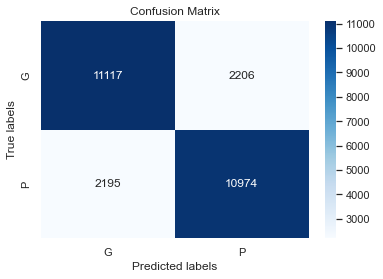

              precision    recall  f1-score   support

           G       0.84      0.83      0.83     13323
           P       0.83      0.83      0.83     13169

    accuracy                           0.83     26492
   macro avg       0.83      0.83      0.83     26492
weighted avg       0.83      0.83      0.83     26492



In [155]:
# Hacer predicciones en el conjunto de prueba
y_preds = modelLRs.predict(X_tests)

# Definir etiquetas para la matriz de confusión
labels = np.unique(y_tests)

# Calcular la matriz de confusión con etiquetas definidas
conf_mat = confusion_matrix(y_tests, y_LRs, labels=labels)

# Graficar la matriz de confusión con etiquetas definidas
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', ax=ax,
            xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

# Imprimir el reporte de clasificación
print(classification_report(y_tests, y_LRs, target_names=labels))

In [145]:
#Creación del modelo 
modelLRovrLinea= LogisticRegression(multi_class = "ovr", solver='liblinear',  random_state=0)
modelLRovrlbfgs= LogisticRegression(multi_class = "ovr", solver='lbfgs',  random_state=0) 
modelLRMullbfgs= LogisticRegression(multi_class = "multinomial", solver='lbfgs',  random_state=0)

#Entrenamiento del modelo con 80% de training
modelLRovrLinea.fit(X_trains, y_trains)
modelLRovrlbfgs.fit(X_trains, y_trains)
modelLRMullbfgs.fit(X_trains, y_trains)

LogisticRegression(multi_class='multinomial', random_state=0)

In [146]:
#Evaluación de los modelos
y_predovrLinea = modelLRovrLinea.predict(X_tests)
y_predovrlbfgs = modelLRovrlbfgs.predict(X_tests)
y_predMullbfgs = modelLRMullbfgs.predict(X_tests)

In [147]:
print("===========Accuracy Logistic Regression ================")

print("ovr - Linear       :",metrics.accuracy_score(y_tests, y_predovrLinea))
print("ovr - lbfgs        :",metrics.accuracy_score(y_tests, y_predovrlbfgs))
print("multinomial - lbfgs:",metrics.accuracy_score(y_tests, y_predMullbfgs))

===========Accuracy Logistic Regression ================
modelLRs: 0.8338743771704665
ovr - Linear       : 0.8338743771704665
ovr - lbfgs        : 0.8338743771704665
multinomial - lbfgs: 0.8336856409482107


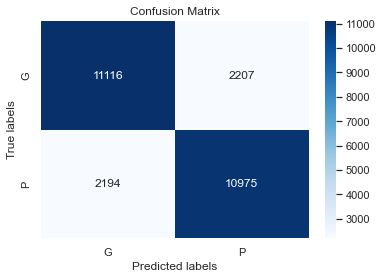

              precision    recall  f1-score   support

           G       0.84      0.83      0.83     13323
           P       0.83      0.83      0.83     13169

    accuracy                           0.83     26492
   macro avg       0.83      0.83      0.83     26492
weighted avg       0.83      0.83      0.83     26492



In [148]:
# Hacer predicciones en el conjunto de prueba
y_preds = modelLRovrLinea.predict(X_tests)

# Definir etiquetas para la matriz de confusión
labels = np.unique(y_tests)

# Calcular la matriz de confusión con etiquetas definidas
conf_mat = confusion_matrix(y_tests, y_predovrLinea, labels=labels)

# Graficar la matriz de confusión con etiquetas definidas
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', ax=ax,
            xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

# Imprimir el reporte de clasificación
print(classification_report(y_tests, y_predovrLinea, target_names=labels))